<a href="https://colab.research.google.com/github/geovalexis/TFG/blob/main/Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Current resources information



In [ ]:
!head -15 /proc/cpuinfo
import threading
print("\nNumber of active threads:", threading.active_count())

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0

Number of active threads: 15


# Data retrievement


## Reference Proteome Dataset

In [ ]:
# Quest for Orthologs (QfO) dataset
!ls drive/MyDrive/TFG/QFO_2018/

# DEPRECATED
# QfO species and statistics
# We got this information from README file of the QfO release 
# It was formatted into a tabulated file by the following command: 
# cat QfO_statistics.txt | tr -s ' ' | cut -f1-6 -d" " | tr ' ' '\t' > QfO_statistics.tsv
!ls drive/MyDrive/TFG/QFO_2018/QfO_statistics.tsv


QfO_statistics.tsv  UP000005640_9606.fasta     UP000005640_9606.idmapping
README		    UP000005640_9606.gene2acc  UP000005640_9606.xml
drive/MyDrive/TFG/QFO_2018/QfO_statistics.tsv
     |████████████████████████████████| 2.3MB 4.7MB/s 
A0A024R161
A0A024R1R8
A0A075B6F4
A0A075B6H5
A0A075B6H7
A0A075B6H8
A0A075B6H9
A0A075B6I0
A0A075B6I1
A0A075B6I3


In [ ]:
# Get QfO species (taxIDs) and all their corresponding uniprotIDs available in the QfO database

#!wget ftp://ftp.ebi.ac.uk/pub/databases/reference_proteomes/previous_releases/qfo_release-2018_04/QfO_release_2018_04.tar.gz 
#!tar -xvzf QfO_release_2018_04.tar.gz --one-top-level

import os
import pandas as pd
qfoDir='./QfO_release_2018_04/'
QfO_proteome = {}
for subdir, dirs, files in os.walk(qfoDir):
    for file in files:
        if file.endswith(".gene2acc"):
            taxID = file.split("_")[1].split(".")[0]
            QfO_proteome[taxID] = pd.read_csv(os.path.join(subdir, file), sep="\t", names=["GeneSymbol", "UniprotKB", "CanonicalGeneSymbol"], usecols=["UniprotKB"])["UniprotKB"]
QfO_proteome = pd.DataFrame(QfO_proteome)
QfO_proteome.head()
QfO_proteome.to_csv("drive/MyDrive/TFG/QFO_2018/QfO_uniprotKBs.tsv", sep="\t", header=True, index=False)
!head drive/MyDrive/TFG/QFO_2018/QfO_uniprotKBs.tsv

243232	188937	273057	69014	64091	374847	436308	243273	251221	1111708	189518	122586	224911	243230	243231	190304	224324	208964	289376	324602	243090	85962	100226	243274	83332	224308	83333	226186	515635	272561	6412	39947	9031	6239	184922	9595	45351	13616	237561	367110	4577	81824	214684	418459	6945	5888	237631	9913	9615	36329	5664	7165	321614	5722	284591	7070	9606	44689	7918	284812	8364	35128	10116	684364	7955	7739	8090	9598	7227	7719	3055	10090	3702	665079	3218	164328	559292	330879
Q60328	Q8TUR2	Q97TX9	P77933	O51955	B1L7D4	A9A4Z2	P47377	Q7NPQ4	P77971	Q8FA34	Q9K1R8	Q89YF1	Q9RYE8	Q74GG6	Q8RHA7	O67904	Q9I7C5	B5YGS5	A9WAN1	Q7UZ97	O24866	O50499	Q9WYH1	P71591	P05648	P23843	Q8ABV9	B8DYG0	O84004	T1ECX9	Q8RZL9	P40666	P34257	A8B2Y5	P30375	A7S0L9	Q28462	A0A1D8PCG7	P22702	P19950	A9V4W6	Q5KQA0	E3JPW3	B7P404	A0BAJ9	Q0H8Y6	Q2M2T3	O97945	Q25823	Q01782	Q7QEI4	A7UG00	A2GII8	Q36258	Q94R76	Q6P435	Q23890	W5LV44	Q9US57	P84383	B8BT19	P01681	F4NY12	P0C8Y2	O47426	Q01798	P30686	Q8T8R6	F7A355	P35006	P01753	Q9SP32	A7

In [ ]:
# Get species taxIDs from QfO (it comes with many strain or subspecie taxIDs)

!pip install --upgrade ete3
from ete3 import NCBITaxa
import pandas as pd

# The first line (header) of the tsv file corresponds to the taxIDs of the reference species
QfO_reference_taxa = pd.read_csv("drive/MyDrive/TFG/QFO_2018/QfO_uniprotKBs.tsv", sep="\t", nrows=0).columns.astype("int32")
QfO_reference_species = [(QfO_reference_taxa[i], *getSpecie(QfO_reference_taxa[i])) for i in range(QfO_reference_taxa.size)]
QfO_reference_species = pd.DataFrame(QfO_reference_species, columns=["QfO_taxID", "specie_taxID", "species_name"])
QfO_reference_species.to_csv("drive/MyDrive/TFG/QFO_2018/subspecieID2specieID.tsv", sep="\t", header=True, index=False)
!head drive/MyDrive/TFG/QFO_2018/subspecieID2specieID.tsv

# Snippet got from mapQfO2MtP.py (Gabaldonlab/qfo-2020 repo) but slightly modified to also output specie's name
def getSpecie(taxID: int):
    """This function searches the corresponding specie taxID for a given strain or subspecie taxID (MUST BE AN INTEGER) in the NCBI database. 
    Args:
        taxID (int): taxID of the taxon of interest.
    Returns:
        specieID (int): taxID of the corresponding specie.
    """
    
    ncbi = NCBITaxa()
    #ncbi.update_taxonomy_database() 
    
    specieID = taxID # If the taxID is already a specie it will return the same taxID
    if ncbi.get_rank([taxID])[taxID] != 'species':
        lineage = ncbi.get_lineage(taxID)
        for j in reversed(lineage): #Reverse because it's faster when it's a strain or subspecie
            if ncbi.get_rank([j])[j] == 'species':
                specieID = j
    species_name = ncbi.get_taxid_translator([specieID])[specieID]
    return specieID, species_name


Requirement already up-to-date: ete3 in /usr/local/lib/python3.6/dist-packages (3.1.2)
QfO_taxID	specie_taxID	species_name
243232	2190	Methanocaldococcus jannaschii
188937	2214	Methanosarcina acetivorans
273057	2287	Saccharolobus solfataricus
69014	311400	Thermococcus kodakarensis
64091	2242	Halobacterium salinarum
374847	498846	Candidatus Korarchaeum cryptofilum
436308	338192	Nitrosopumilus maritimus
243273	2097	Mycoplasma genitalium
251221	33072	Gloeobacter violaceus


In [ ]:
# Human referece proteome dataset - CANONICAL PROTEOME
# These are only the canonical proteins (in the xml are only the canonical sequences).
# We are not adding isoforms or variants proteins so far.
# This is the reason why we do not take the uniprotIDs directly from the previous file.

!pip install biopython
from Bio import SeqIO
import pandas as pd
records = list(SeqIO.parse("drive/MyDrive/TFG/QFO_2018/UP000005640_9606.xml", "seqxml"))
records_ids = [record.id for record in records]
df_records_ids = pd.DataFrame(records_ids)
df_records_ids.to_csv("drive/MyDrive/TFG/QFO_2018/human_reference_proteome.tsv", sep="\t", index=False, header=False)
!head drive/MyDrive/TFG/QFO_2018/human_reference_proteome.tsv

A0A024R161
A0A024R1R8
A0A075B6F4
A0A075B6H5
A0A075B6H7
A0A075B6H8
A0A075B6H9
A0A075B6I0
A0A075B6I1
A0A075B6I3


## Gene Ontology Annotation (GAF) 


In [1]:
# Last version available at 15/01/2021
!wget ftp://ftp.ebi.ac.uk/pub/databases/GO/goa/UNIPROT/goa_uniprot_all.gaf.gz # See https://www.ebi.ac.uk/GOA/ and https://www.ebi.ac.uk/QuickGO/annotations
!zcat goa_uniprot_all.gaf.gz | head -n 10

--2021-01-15 16:13:11--  ftp://ftp.ebi.ac.uk/pub/databases/GO/goa/UNIPROT/goa_uniprot_all.gaf.gz
           => ‘goa_uniprot_all.gaf.gz’
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.138
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.138|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/databases/GO/goa/UNIPROT ... done.
==> SIZE goa_uniprot_all.gaf.gz ... 13279844972
==> PASV ... done.    ==> RETR goa_uniprot_all.gaf.gz ... done.
Length: 13279844972 (12G) (unauthoritative)

goa_uniprot_all.gaf 100%[===================>]  12.37G  11.5MB/s    in 17m 58s 

2021-01-15 16:31:11 (11.8 MB/s) - Control connection closed.
Retrying.

--2021-01-15 16:46:13--  ftp://ftp.ebi.ac.uk/pub/databases/GO/goa/UNIPROT/goa_uniprot_all.gaf.gz
  (try: 2) => ‘goa_uniprot_all.gaf.gz’
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.138|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... d

## Orthologs retrievement

### From MetaPhors

In [ ]:
!ls drive/MyDrive/TFG/QfO_input.tsv #Orthologs input for QfO

drive/MyDrive/TFG/QfO_input.tsv


# Matrix creation


### Mapping human genes to orthologs and taxIDs 

Mapping Homo Sapiens reference proteins to their correspoding orthologs (from 78 reference species set by QfO) and its taxIDs


In [ ]:
# DIFFERENT WAYS OF LOOKING FOR THE TAXID FROM THE UNIPROTID

%%time
import numpy as np
import requests

def map_uniprotIDs2taxIDs_BruteForce(uniprotIDs):
  qfo_uniprotIDs = pd.read_csv("drive/MyDrive/TFG/QFO_2018/QfO_uniprotKBs.tsv", sep="\t", header=0, dtype="string")
  qfo_uniprotIDs.fillna("-", inplace=True) #To solve "boolean value of NA is ambiguous pandas" error
  taxIDs = []
  for uniprotID in uniprotIDs:
    found = False
    for taxID in qfo_uniprotIDs:
        if uniprotID in qfo_uniprotIDs[taxID].unique():
            taxIDs.append(taxID)
            found = True
            break
    if not found:
        taxIDs.append(np.nan)
  return taxIDs

def map_uniprotIDs2taxIDs_UniprotRequest(uniprotIDs):
    # Documentation in https://www.uniprot.org/help/api_queries
    taxIDs = []
    endpoint = "https://www.uniprot.org/uniprot/"
    for uniprotID in uniprotIDs:
        params = {
            'query': uniprotID,
            'columns': 'organism-id', #Other information can be added (just add the field in comma-separated). Ex. 'id,organism-id,genes'
            'format': 'tab'
        }
        response = requests.get(endpoint, params=params)
        if response.status_code == 200:
            taxIDs.append(response.text.splitlines()[1])
        else:
            print(f"The tax for {uniprotID} couldn't be found")
            taxIDs.append(np.nan)
    return taxIDs

def map_uniprotIDs2taxIDs_EBIRequest(uniprotIDs):
    # Documentation in https://www.ebi.ac.uk/proteins/api/doc/
    taxIDs = []
    for uniprotID in uniprotIDs:
        requestURL = f"https://www.ebi.ac.uk/proteins/api/proteins/{uniprotID}"
        response = requests.get(requestURL, headers={ "Accept" : "application/json"})
        if response.ok: # status_code == 200
            taxIDs.append(response.json()["organism"]["taxonomy"])
        else:
            print(f"The tax for {uniprotID} couldn't be found")
            taxIDs.append(np.nan)
    return taxIDs

print(map_uniprotIDs2taxIDs_EBIRequest(["Q7ZAM9", "Q8F6D0", "Q8F6A3", "Q8F692", "Q8F624", "Q7L211", "Q8CXT3"]))


[189518, 189518, 189518, 189518, 189518, 9606, 189518]
CPU times: user 93.4 ms, sys: 14.9 ms, total: 108 ms
Wall time: 4 s


In [ ]:
# MULTIPROCESSING VERSION OF map_uniprotIDs2taxIDs_EBIRequest

#!pip install aiohttp
#!pip install asyncio

# TO SOLVE "This event loop is already running in python" error
#!pip install nest_asyncio
#import nest_asyncio
#nest_asyncio.apply()
%%time

import pandas as pd
import aiohttp
import asyncio

async def map_uniprotIDs2taxIDs_EBIRequest(uniprotID, session):
    # Documentation in https://www.ebi.ac.uk/proteins/api/doc/
    while True:
        try:
            requestURL = f"https://www.ebi.ac.uk/proteins/api/proteins/{uniprotID}"
            response = await session.get(requestURL, headers={ "Accept" : "application/json"})
            if response.ok: # status_code == 200
                return {uniprotID:(await response.json())["organism"]["taxonomy"]}
            else:
                print(f"Protein {uniprotID} raised a {response.status} status code.")
                return {uniprotID: pd.NA}
        except aiohttp.ClientConnectionError as e:
            print(f"Raised a ClientConnectionError: {e.message}")
            asyncio.sleep(0.1)

async def map_uniprotIDs2taxIDs_EBIRequest_multiprocessing(uniprotIDs, chunk=200): # EBI limits requests to 200 requests/second/user
  result = {}
  async with aiohttp.ClientSession() as session:
    if len(uniprotIDs)>chunk:
        for i in range(0, len(uniprotIDs), chunk):
            step = i+chunk if (i+chunk) < len(uniprotIDs) else len(uniprotIDs)
            print(f"{i} proteins already processed. Processing next batch...")
            res_batch = await asyncio.gather(*[map_uniprotIDs2taxIDs_EBIRequest(uniprotID, session) for uniprotID in uniprotIDs[i:step]])
            for j in res_batch:
                result.update(j)
            #sleep(1)
    else:
        res_batch = await asyncio.gather(*[map_uniprotIDs2taxIDs_EBIRequest(uniprotID, session) for uniprotID in uniprotIDs])
        for j in res_batch:
            result.update(j)
  return result


uniprotIDs = pd.Series(["Q7ZAM9", "Q8F6D0", "NO_EXIST", "Q8F692", "Q8F624", "Q7L211", "Q8CXT3"])
loop = asyncio.get_event_loop()
uniprotID2taxIDs = loop.run_until_complete(map_uniprotIDs2taxIDs_EBIRequest_multiprocessing(uniprotIDs.unique().tolist(), 3))
uniprotIDs = uniprotIDs.apply(lambda x:  uniprotID2taxIDs.get(x))
#uniprotIDs = uniprotIDs.astype(pd.Int64Dtype())
print(uniprotIDs)


Processing next batch: 3.
Protein NO_EXIST raised a 400 status code.
Processing next batch: 6.
Processing next batch: 9.
0    189518
1    189518
2      <NA>
3    189518
4    189518
5      9606
6    189518
dtype: object
CPU times: user 30.3 ms, sys: 2.18 ms, total: 32.5 ms
Wall time: 2.66 s


In [ ]:
%%time
!pip install aiohttp
!pip install asyncio

import pandas as pd
import aiohttp
import asyncio

# To solve "This event loop is already running in python" error
!pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()

# GET ORTHOLOGS ONLY FOR HOMO SAPIENS
mtp_orthologs = pd.read_csv("drive/MyDrive/TFG/QfO_input.tsv", sep="\t", names=["protein1", "protein2"])
qfo_ref_human_proteome = pd.read_csv("drive/MyDrive/TFG/QFO_2018/human_reference_proteome.tsv", sep="\t", names=["protein1"])
print("Total size of the orthologs file from MetaPhOrs:", mtp_orthologs.size)
print("Number of reference proteins (from QfO):", qfo_ref_human_proteome.size)
ref_protein_mtp = pd.merge(mtp_orthologs, qfo_ref_human_proteome, how="inner", on="protein1")
print("Size of the resulting inner join between the two datasets:", ref_protein_mtp.size)
print("Actual number of reference Homo Sapiens proteins within MetaPhOrs:", ref_protein_mtp["protein1"].unique().size)
#ref_protein_mtp.drop_duplicates() # There just around 200 repeated rows but I think that they correspond to the orthologs within the same specie (Homo sapiens in this case) -> diagonal

async def map_uniprotIDs2taxIDs_EBIRequest(uniprotID, session):
    # Documentation in https://www.ebi.ac.uk/proteins/api/doc/
    while True:
        try:
            requestURL = f"https://www.ebi.ac.uk/proteins/api/proteins/{uniprotID}"
            response = await session.get(requestURL, headers={ "Accept" : "application/json"})
            if response.ok: # status_code == 200
                return {uniprotID:(await response.json())["organism"]["taxonomy"]}
            else:
                #print(f"Protein {uniprotID} raised a {response.status} status code.") # It means that the protein couldn't be found or has been deleted.
                return {uniprotID: pd.NA}
        except aiohttp.ClientConnectionError as e:
            print(f"Raised a ClientConnectionError: {e.message}")
            asyncio.sleep(0.1)

async def map_uniprotIDs2taxIDs_EBIRequest_multiprocessing(uniprotIDs, chunk=200): # EBI limits requests to 200 requests/second/user
  result = {}
  async with aiohttp.ClientSession() as session:
    if len(uniprotIDs)>chunk:
        for i in range(0, len(uniprotIDs), chunk):
            step = i+chunk if (i+chunk) < len(uniprotIDs) else len(uniprotIDs)
            #print(f"{i} proteins already processed. Processing next batch...")
            res_batch = await asyncio.gather(*[map_uniprotIDs2taxIDs_EBIRequest(uniprotID, session) for uniprotID in uniprotIDs[i:step]])
            for j in res_batch:
                result.update(j)
            #sleep(1)
    else:
        res_batch = await asyncio.gather(*[map_uniprotIDs2taxIDs_EBIRequest(uniprotID, session) for uniprotID in uniprotIDs])
        for j in res_batch:
            result.update(j)
  return result

# MAP TAXIDs
loop = asyncio.get_event_loop()
uniprotID2taxIDs = loop.run_until_complete(map_uniprotIDs2taxIDs_EBIRequest_multiprocessing(ref_protein_mtp["protein2"].unique().tolist()))
ref_protein_mtp["orthologs_taxID"] = ref_protein_mtp["protein2"].apply(lambda x:  uniprotID2taxIDs.get(x))
#ref_protein_mtp["orthologs_taxID"] = ref_protein_mtp["orthologs_taxID"].astype(pd.Int64Dtype())
ref_protein_mtp.to_csv("drive/MyDrive/TFG/human_orthologs_MtP-QfO2018.tsv", sep="\t", index=False, header=["human_protein", "ortholog", "orthologs_taxID"])
!echo "First 10 rows:"
!head -10 drive/MyDrive/TFG/human_orthologs_MtP-QfO2018.tsv



Total size of the orthologs file from MetaPhOrs: 7898268
Number of reference proteins (from QfO): 20996
Size of the resulting inner join between the two datasets: 139718
Actual number of reference Homo Sapiens proteins within MetaPhOrs: 5254
First 10 rows:
human_protein	ortholog	orthologs_taxID
Q8ND71	Q7ZAM9	189518
Q8ND71	Q6CDT3	284591
Q8ND71	A2ESR8	5722
Q8ND71	A2E1H0	5722
Q8ND71	A2FTJ3	5722
Q8ND71	A2FTJ2	5722
Q8ND71	G3S4T9	9595
Q8ND71	A0A2I3SJI4	9598
Q8ND71	H2R4V7	9598
CPU times: user 1min 7s, sys: 4.83 s, total: 1min 11s
Wall time: 16min 38s


In [ ]:
# Orthologs analysis
import pandas as pd

human_orthologs = pd.read_csv("drive/MyDrive/TFG/human_orthologs_MtP-QfO2018.tsv", sep="\t", header=0, dtype={"human_protein": "string", "ortholog":"string", "orthologs_taxID":pd.Int64Dtype()})
print(f"There are {human_orthologs['human_protein'].unique().size} human proteins and {human_orthologs['ortholog'].size} orthologs.")
print(f"There are {human_orthologs['orthologs_taxID'].isna().sum()} proteins that have been deleted from the Uniprot database")
# Se podría buscar los taxIDs de estas proteinas en el fichero de QfO_uniprotKBs.tsv (aquí seguro que están) mediante la funcion map_uniprotIDs2taxIDs_BruteForce()
# Aunque si no es una cifra significativa tal vez no sea necesario o bien incluso sería mejor ignorarlas dado que por algo han sido eliminadas

There are 5254 human proteins and 69859 orthologs.
There are 1618 proteins that have been deleted from the Uniprot database


### Count orthologs per human protein

In [ ]:
import pandas as pd
import numpy as np

human_orthologs = pd.read_csv("drive/MyDrive/TFG/human_orthologs_MtP-QfO2018.tsv", sep="\t", header=0, dtype={"human_protein": "string", "ortholog":"string", "orthologs_taxID":pd.Int64Dtype()})
sub2sp = pd.read_csv("drive/MyDrive/TFG/QFO_2018/subspecieID2specieID.tsv", sep="\t", header=0, dtype={"QfO_taxID":pd.Int64Dtype(), "specie_taxID": pd.Int64Dtype(), "species_name": "string"})

# Clean and check
#print("Species taxIDs:\n",sub2sp["QfO_taxID"].unique())
#print("\nOrthologs taxIDs:\n", human_orthologs["orthologs_taxID"].dropna().unique())
print("\nSpecies in the reference proteome for which any ortholog has been found:\n",np.setdiff1d(sub2sp["QfO_taxID"].unique(), human_orthologs["orthologs_taxID"].dropna().unique()))
print("\nOrthologs species that are not in the reference proteome:\n", np.setdiff1d(human_orthologs["orthologs_taxID"].dropna().unique(), sub2sp["QfO_taxID"].unique()))

# Count orthologs
taxa = np.intersect1d(sub2sp["QfO_taxID"].unique(), human_orthologs["orthologs_taxID"].dropna().unique())
proteins = human_orthologs["human_protein"].unique()
matrix = {}
for tax in taxa:
  tax_orthologs = human_orthologs[human_orthologs["orthologs_taxID"]==tax] # Orthologs between human and a specific specie
  matrix[tax] = []
  for protein in proteins:
    query = tax_orthologs["ortholog"].where(tax_orthologs["human_protein"]==protein).dropna() #To just count the nº of orthologs replace tolist() with count()
    if query.empty:
      matrix[tax].append([])
    else:
      matrix[tax].append(query.tolist())
orthologs_matrix_df = pd.DataFrame(matrix, index=proteins)
orthologs_counts_matrix = orthologs_matrix_df.applymap(lambda x: len(x))
orthologs_counts_matrix.to_csv("drive/MyDrive/TFG/orthologs_counts_matrix.tsv", sep="\t", index=True, header=True)
orthologs_counts_matrix

# orthologs_counts_matrix[orthologs_counts_matrix[orthologs_counts_matrix[:]!=0].all(axis=1)] # Eliminar todas aquellas filas en las haya todo 0s

# PARA PRUEBAS:
# prova = ["Q8ND71", "Q7L211", "Q5JPI9"]
# tax_orthologs = human_orthologs[human_orthologs["orthologs_taxID"]==9598]
# print(tax_orthologs)
# for protein in prova:
#   print(tax_orthologs["ortholog"].where(tax_orthologs["human_protein"]==protein).dropna().tolist()) 



Species in the reference proteome for which any ortholog has been found:
 [7918 9606 83332 184922 224308 243273 559292 684364]

Orthologs species that are not in the reference proteome:
 []


,3055,3218,3702,4577,5664,5722,5888,6239,6412,6945,7070,7165,7227,7719,7739,7955,8090,8364,9031,9595,9598,9615,9913,10090,10116,13616,35128,36329,39947,44689,45351,64091,69014,81824,83333,85962,100226,122586,164328,188937,189518,190304,208964,214684,224324,224911,226186,237561,237631,243090,243230,243231,243232,243274,251221,272561,273057,284591,284812,289376,321614,324602,330879,367110,374847,418459,436308,515635,665079,1111708
Q8ND71,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
P15170,1,0,0,1,1,1,0,1,1,1,1,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0
Q6ZNB7,0,0,0,0,0,0,0,0,0,0,1,0,0,0,4,1,1,1,1,1,0,0,1,1,0,1,0,0,0,2,1,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A6NK44,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,1,1,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
A5YM72,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q8N1W1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A0A0A0MSL8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
P20930,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A0A1B0GTG1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## GO assignment

#Phylogenetic Profiling (PP)


## Some visualization

In [ ]:
#orthologs_counts_matrix[orthologs_counts_matrix[7739]>10] # 7739 has a high number of orthologs
# Maximum value found in the dataset:
orthologs_counts_matrix.max().max()

196

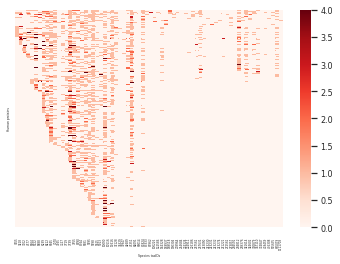

In [39]:
import seaborn as sb
import matplotlib.pyplot as plt

sb.set(font_scale=0.25) # So that all the x labels can fit within the graph
heat_map = sb.heatmap(orthologs_counts_matrix, cmap="Reds",  yticklabels=False, vmin=0, vmax=4) # The max nº of orthologs that has been found is 196, so we need to cut this off in order to have a good visualization
#plt.figure(figsize=(16,9))
# plt.tight_layout() # For avoiding matplot from saving the image with x label cut off
# Change fontsize of the color bar 
colorbar = heat_map.collections[0].colorbar
colorbar.ax.tick_params(labelsize=8)
plt.ylabel('Human proteins')
plt.xlabel("Species taxIDs")
plt.savefig('drive/MyDrive/TFG/orthologs_counts_heatmap.png', dpi=300)
plt.show()


## Correlation Matrix


Any of the differente distance metrics (cosine, hammington, hamming..) will be used for directly assign pair-wise comparison of the vectors.

In [28]:
orthologs_counts_matrix = pd.read_csv("drive/MyDrive/TFG/orthologs_counts_matrix.tsv", sep="\t", header=0, index_col=0)
orthologs_counts_matrix_presence_absence = orthologs_counts_matrix.applymap(lambda x: 1 if x >= 1 else 0)


### With Hamming distance

In [29]:
import numpy as np
import pandas as pd

# Manual implementation of the matrix:
def HammingDistance(v1: np.array, v2: np.array):
  return np.count_nonzero(np.bitwise_xor(v1, v2) == 1)

# v1 = np.array([1,0])
# v2 = np.array([1,1])
# HammingDistance(v1,v2)


# Automatic implementation of the matrix (Normalized):
from sklearn.metrics import pairwise_distances

X = pd.DataFrame(pairwise_distances(orthologs_counts_matrix_presence_absence, metric="hamming"))
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,5214,5215,5216,5217,5218,5219,5220,5221,5222,5223,5224,5225,5226,5227,5228,5229,5230,5231,5232,5233,5234,5235,5236,5237,5238,5239,5240,5241,5242,5243,5244,5245,5246,5247,5248,5249,5250,5251,5252,5253
0,0.000000,0.342857,0.242857,0.328571,0.128571,0.385714,0.314286,0.128571,0.214286,0.228571,0.342857,0.214286,0.242857,0.142857,0.228571,0.185714,0.300000,0.428571,0.314286,0.271429,0.171429,0.357143,0.257143,0.471429,0.200000,0.085714,0.114286,0.357143,0.114286,0.228571,0.271429,0.428571,0.314286,0.300000,0.342857,0.542857,0.385714,0.385714,0.271429,0.314286,...,0.100000,0.085714,0.085714,0.100000,0.100000,0.085714,0.085714,0.085714,0.085714,0.100000,0.085714,0.085714,0.085714,0.085714,0.085714,0.085714,0.085714,0.085714,0.085714,0.085714,0.071429,0.071429,0.085714,0.085714,0.085714,0.085714,0.071429,0.085714,0.085714,0.085714,0.085714,0.085714,0.085714,0.085714,0.085714,0.100000,0.085714,0.085714,0.085714,0.085714
1,0.342857,0.000000,0.328571,0.471429,0.271429,0.242857,0.314286,0.385714,0.357143,0.371429,0.428571,0.300000,0.214286,0.314286,0.342857,0.300000,0.328571,0.285714,0.342857,0.328571,0.314286,0.242857,0.314286,0.242857,0.257143,0.314286,0.228571,0.528571,0.342857,0.342857,0.214286,0.285714,0.285714,0.385714,0.400000,0.342857,0.328571,0.300000,0.357143,0.228571,...,0.357143,0.342857,0.342857,0.357143,0.328571,0.342857,0.342857,0.342857,0.342857,0.328571,0.342857,0.342857,0.342857,0.342857,0.342857,0.342857,0.342857,0.342857,0.342857,0.342857,0.328571,0.328571,0.342857,0.342857,0.342857,0.342857,0.328571,0.342857,0.342857,0.342857,0.314286,0.314286,0.314286,0.314286,0.314286,0.300000,0.314286,0.314286,0.314286,0.314286
2,0.242857,0.328571,0.000000,0.314286,0.257143,0.342857,0.242857,0.142857,0.228571,0.214286,0.357143,0.285714,0.228571,0.214286,0.185714,0.200000,0.228571,0.385714,0.271429,0.285714,0.214286,0.342857,0.242857,0.400000,0.214286,0.185714,0.242857,0.485714,0.185714,0.271429,0.200000,0.357143,0.271429,0.342857,0.328571,0.471429,0.428571,0.314286,0.342857,0.300000,...,0.228571,0.242857,0.242857,0.228571,0.228571,0.214286,0.214286,0.214286,0.214286,0.200000,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.228571,0.228571,0.214286,0.214286,0.214286,0.214286,0.228571,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.200000,0.214286,0.214286,0.214286,0.214286
3,0.328571,0.471429,0.314286,0.000000,0.342857,0.485714,0.328571,0.285714,0.342857,0.328571,0.357143,0.400000,0.371429,0.271429,0.271429,0.285714,0.371429,0.385714,0.300000,0.285714,0.328571,0.485714,0.328571,0.571429,0.385714,0.328571,0.300000,0.485714,0.300000,0.357143,0.342857,0.442857,0.414286,0.342857,0.328571,0.442857,0.457143,0.428571,0.400000,0.414286,...,0.342857,0.328571,0.328571,0.342857,0.314286,0.328571,0.328571,0.328571,0.328571,0.314286,0.328571,0.328571,0.328571,0.328571,0.328571,0.328571,0.328571,0.328571,0.328571,0.328571,0.314286,0.314286,0.328571,0.328571,0.328571,0.328571,0.314286,0.328571,0.328571,0.328571,0.300000,0.300000,0.300000,0.300000,0.300000,0.314286,0.300000,0.300000,0.328571,0.328571
4,0.128571,0.271429,0.257143,0.342857,0.000000,0.371429,0.357143,0.200000,0.228571,0.214286,0.357143,0.228571,0.314286,0.157143,0.242857,0.171429,0.342857,0.414286,0.271429,0.257143,0.214286,0.342857,0.271429,0.428571,0.214286,0.071429,0.128571,0.400000,0.128571,0.271429,0.285714,0.385714,0.357143,0.314286,0.357143,0.471429,0.342857,0.314286,0.285714,0.300000,...,0.114286,0.100000,0.100000,0.114286,0.114286,0.100000,0.100000,0.100000,0.100000,0.114286,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.085714,0.085714,0.100000,0.100000,0.100000,0.100000,0.085714,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.114286,0.100000,0.100000,0.100000,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...

### With Jaccart distance

In [34]:
from sklearn.metrics import pairwise_distances

pairwise_distances(orthologs_counts_matrix_presence_absence, metric="jaccard")

AttributeError: ignored

## Clustering methods

Remember that clustering is part of Unsupervised Machine Learning

### K-means

In [10]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

orthologs_counts_matrix = pd.read_csv("drive/MyDrive/TFG/orthologs_counts_matrix.tsv", sep="\t", header=0, index_col=0)
orthologs_counts_matrix_presence_absence = orthologs_counts_matrix.applymap(lambda x: 1 if x >= 1 else 0)
orthologs_counts_matrix_presence_absence.head()

X_std = orthologs_counts_matrix_presence_absence #StandardScaler().fit_transform(orthologs_counts_matrix_presence_absence)
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(X_std)
clusters

array([6, 3, 9, ..., 5, 5, 5], dtype=int32)

#### Visualizing with PCA

Text(0, 0.5, 'PCA 2')

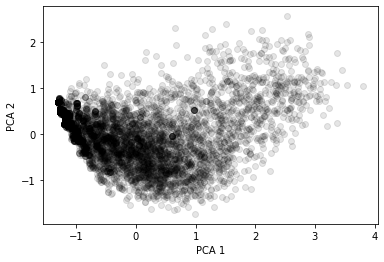

In [11]:
# Credits: https://medium.com/@dmitriy.kavyazin/principal-component-analysis-and-k-means-clustering-to-visualize-a-high-dimensional-dataset-577b2a7a5fe2

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler

# Standardize the data to have a mean of ~0 and a variance of 1
X_std = orthologs_counts_matrix_presence_absence #StandardScaler().fit_transform(orthologs_counts_matrix_presence_absence)

# Create a PCA instance: pca
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_std)
PCA_components = pd.DataFrame(principalComponents)
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')


### Hierarchical clustering

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


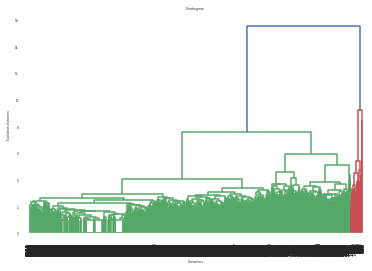

In [41]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import pandas as pd

dendrogram = sch.dendrogram(sch.linkage(X, method  = "average"))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

# clustering = AgglomerativeClustering(linkage="average", affinity="precomputed").fit(X)
# clustering.n_clusters_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """


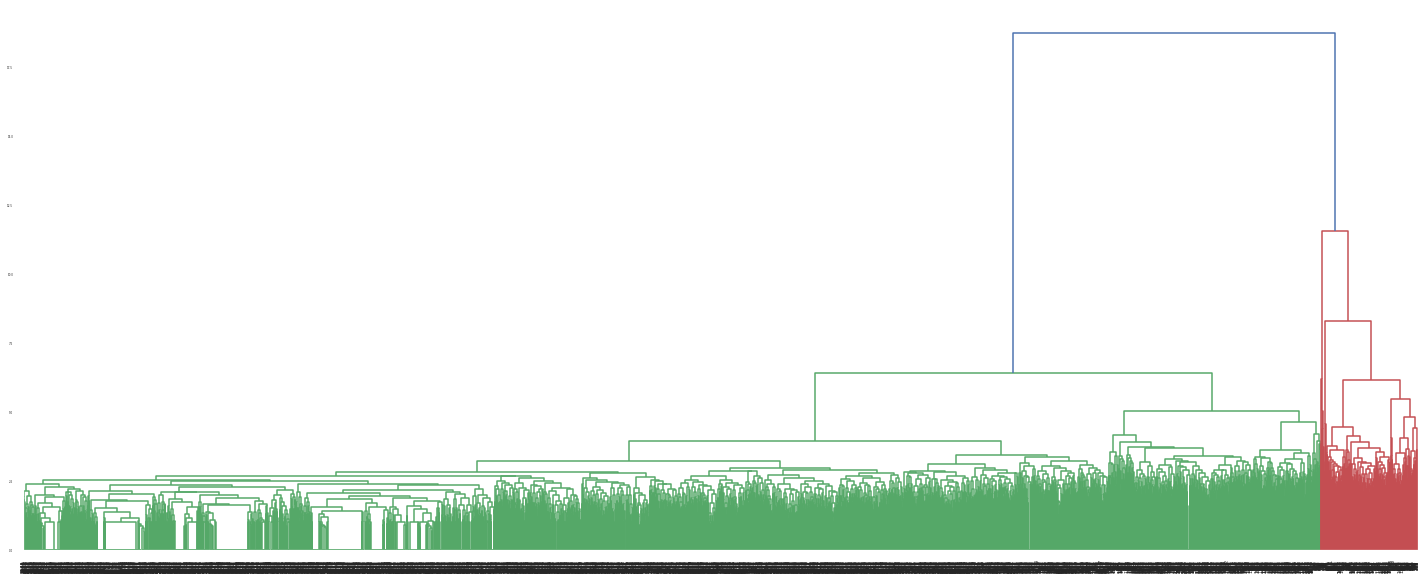

2660


In [64]:
# Snippet of code inspired from this paper https://www.embopress.org/doi/full/10.1038/msb.2013.50#msb201350-fig-0001 (within the "Generation of coevolved gene clusters")

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

Z = linkage(X, 'weighted', metric="Euclidean")
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.show()

# Number of different clusters
print(len(set(fcluster(Z, t=0, criterion='inconsistent'))))

# Supervise Machine Learning

## With single classification models

When a gene has several GO terms, they are reduced to just one: the Lowest Common Ancestor (LCA). 

## With multi-label (various GO terms) classification models